# DRM Project
**Stock Chosen:** Infosys Limited 

**Stock Ticker:** INFY 

In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import exp

## Data Collection

The next segment covers extraction of the required datasets and calculation of annualized volatility.

The stock & options data has been extracted using the NSE API which accesses the NSE Bhavcopy archives.

In [2]:
#Import Options data
temp = pd.read_csv('INFY_data.csv')
temp['Date'] = pd.to_datetime(temp['Date'])
temp['Expiry'] = pd.to_datetime(temp['Expiry'])
temp = temp.rename(columns={'Spot': 'S_0'})

#Extract Expiry Spot Price
options_df = temp.copy()
options_df = options_df.merge(options_df[['Date', 'S_0']].rename(columns={'S_0': 'S_Expiry'}), how='left', left_on='Expiry', right_on='Date')
options_df = options_df.drop(columns=['Date_y']).rename(columns={'Date_x': 'Date'})

#Compute log returns
options_df["Log_Return"] = (options_df["S_0"] / options_df["S_0"].shift(1)).apply(np.log)

#Reorder columns for better readability
options_df = options_df.dropna(subset = ["Log_Return", "S_Expiry"])
options_df = options_df[['Date', 'Expiry', 'S_0', 'S_Expiry', 'Strike', 'Call', 'Put', "Log_Return"]]

pd.options.display.float_format = '{:.2f}'.format
options_df.head(10)

,Date,Expiry,S_0,S_Expiry,Strike,Call,Put,Log_Return
1,2022-07-04,2022-07-28,1488.00,1517.40,1480.00,45.85,36.90,0.01
2,2022-07-05,2022-07-28,1475.95,1517.40,1480.00,39.55,43.65,-0.01
3,2022-07-06,2022-07-28,1491.65,1517.40,1500.00,34.15,42.10,0.01
4,2022-07-07,2022-07-28,1498.70,1517.40,1500.00,39.90,35.35,0.00
5,2022-07-08,2022-07-28,1514.45,1517.40,1520.00,34.90,37.95,0.01
6,2022-07-11,2022-07-28,1473.15,1517.40,1480.00,34.60,40.75,-0.03
7,2022-07-12,2022-07-28,1438.60,1517.40,1440.00,40.85,38.20,-0.02
8,2022-07-13,2022-07-28,1444.45,1517.40,1440.00,41.95,32.05,0.00
9,2022-07-14,2022-07-28,1428.85,1517.40,1420.00,42.50,29.45,-0.01
10,2022-07-15,2022-07-28,1430.35,1517.40,1440.00,31.60,35.00,0.00


In [3]:
#Computing Implied Volatility
trading_days = 252 # Given in the assignment document
daily_vol = options_df["Log_Return"].std()
annualized_vol = daily_vol * (trading_days ** 0.5) 

print(f"The annualized volatility is {annualized_vol:.4f}.")

The annualized volatility is 0.2430.


## Task A: Synthetic Option Portfolio

Let strategy A be buying an actual call and strategy B be buying a synthetic call (Long Stock + Long Put). Let's simulate trades for the available data and compare the 2 strategies using holistic metrics.

In [4]:
r = 0.055   #Risk Free Rate estimated from RBI Repo Rate

# Put Call Parity: C = S + P - K * exp(-rT)
portfolio_df = options_df.copy()
portfolio_df['T'] = (portfolio_df['Expiry'] - portfolio_df['Date']).dt.days / 365
portfolio_df.loc[portfolio_df['T'] <= 0, 'T'] = np.nan
portfolio_df['Synthetic_Call'] = (portfolio_df['S_0'] + portfolio_df['Put'] - portfolio_df['Strike'] * np.exp(-r * portfolio_df['T']))
portfolio_df['Mispricing'] = (portfolio_df['Call'] - portfolio_df['Synthetic_Call'])

# Profit = max(S_T - K, 0) - Actual Call Price
portfolio_df['Payoff_A'] = np.maximum(portfolio_df['S_Expiry'] - portfolio_df['Strike'], 0)
portfolio_df['PnL_A'] = (portfolio_df['Payoff_A'] - portfolio_df['Call'])

# Profit = S_T + max(K - S_T, 0) - (S_0 + P)
portfolio_df['Payoff_B'] = (portfolio_df['S_Expiry'] + np.maximum(portfolio_df['Strike'] - portfolio_df['S_Expiry'], 0))
portfolio_df['PnL_B'] = (portfolio_df['Payoff_B'] - (portfolio_df['S_0'] + portfolio_df['Put']))

portfolio_df['RoC_Actual'] = (portfolio_df['PnL_A'] / portfolio_df['Call'].replace(0, np.nan))
portfolio_df['RoC_Synthetic'] = (portfolio_df['PnL_B'] / (portfolio_df['S_0'] + portfolio_df['Put']).replace(0, np.nan))

# Reorder columns for better readability
portfolio_df = portfolio_df[[
    'Date',
    'Expiry',
    'Strike',
    'Put',
    'Call',
    'S_0',
    'S_Expiry',
    'Mispricing',
    'PnL_A',
    'PnL_B',
    'RoC_Actual',
    'RoC_Synthetic'
]]

pd.options.display.float_format = '{:.4f}'.format
portfolio_df.head(10)

,Date,Expiry,Strike,Put,Call,S_0,S_Expiry,Mispricing,PnL_A,PnL_B,RoC_Actual,RoC_Synthetic
1,2022-07-04,2022-07-28,1480.0000,36.9000,45.8500,1488.0000,1517.4000,-4.3927,-8.4500,-7.5000,-0.1843,-0.0049
2,2022-07-05,2022-07-28,1480.0000,43.6500,39.5500,1475.9500,1517.4000,-5.1704,-2.1500,-2.2000,-0.0544,-0.0014
3,2022-07-06,2022-07-28,1500.0000,42.1000,34.1500,1491.6500,1517.4000,-4.5644,-16.7500,-16.3500,-0.4905,-0.0107
4,2022-07-07,2022-07-28,1500.0000,35.3500,39.9000,1498.7000,1517.4000,1.1109,-22.5000,-16.6500,-0.5639,-0.0109
5,2022-07-08,2022-07-28,1520.0000,37.9500,34.9000,1514.4500,1517.4000,-2.0739,-34.9000,-32.4000,-1.0000,-0.0209
6,2022-07-11,2022-07-28,1480.0000,40.7500,34.6000,1473.1500,1517.4000,-3.0864,2.8000,3.5000,0.0809,0.0023
7,2022-07-12,2022-07-28,1440.0000,38.2000,40.8500,1438.6000,1517.4000,0.5824,36.5500,40.6000,0.8947,0.0275
8,2022-07-13,2022-07-28,1440.0000,32.0500,41.9500,1444.4500,1517.4000,2.1989,35.4500,40.9000,0.8451,0.0277
9,2022-07-14,2022-07-28,1420.0000,29.4500,42.5000,1428.8500,1517.4000,1.2075,54.9000,59.1000,1.2918,0.0405
10,2022-07-15,2022-07-28,1440.0000,35.0000,31.6000,1430.3500,1517.4000,3.4319,45.8000,52.0500,1.4494,0.0355


In [5]:
#Generate performance comparison table
performance_table = pd.DataFrame({
    'Metric': [ 'Total Trades Profitable', 'Avg. Return per Trade', 'Avg. RoC per Trade', 'Max Single Trade Profit', 'Max Single Trade RoC', 'Max Single Trade Loss', 'Min Single Trade RoC' ],
    'Actual Call': [(portfolio_df['PnL_A'] > 0).sum(), portfolio_df['PnL_A'].mean(), portfolio_df['RoC_Actual'].mean(), portfolio_df['PnL_A'].max(), portfolio_df['RoC_Actual'].max(), portfolio_df['PnL_A'].min(), portfolio_df['RoC_Actual'].min()],
    'Synthetic Call': [(portfolio_df['PnL_B'] > 0).sum(), portfolio_df['PnL_B'].mean(), portfolio_df['RoC_Synthetic'].mean(), portfolio_df['PnL_B'].max(), portfolio_df['RoC_Synthetic'].max(), portfolio_df['PnL_B'].min(), portfolio_df['RoC_Synthetic'].min()]
})

performance_table['Winner'] = performance_table.apply( 
    lambda row: ( 'Actual' if row['Actual Call'] > row['Synthetic Call']
    else 'Synthetic' if row['Synthetic Call'] > row['Actual Call'] else 'Tie'), axis=1
)

performance_table

,Metric,Actual Call,Synthetic Call,Winner
0,Total Trades Profitable,167.0000,168.0000,Synthetic
1,Avg. Return per Trade,-1.3422,1.2170,Synthetic
2,Avg. RoC per Trade,0.1975,0.0012,Actual
3,Max Single Trade Profit,135.1500,139.5000,Synthetic
4,Max Single Trade RoC,38.5000,0.0970,Actual
5,Max Single Trade Loss,-53.7000,-46.3000,Synthetic
6,Min Single Trade RoC,-1.0000,-0.0314,Synthetic


In [6]:
#Identify dates of maximum profit and RoC for both strategies
print(f"The maximum profit, {portfolio_df['PnL_A'].max():.2f}, from Actual Call strategy was observed on {portfolio_df.loc[portfolio_df['PnL_A'].idxmax(), 'Date'].date()}.")
print(f"The maximum profit, {portfolio_df['PnL_B'].max():.2f}, from Synthetic Call strategy was observed on {portfolio_df.loc[portfolio_df['PnL_B'].idxmax(), 'Date'].date()}.")

print(f"\nThe maximum RoC, {portfolio_df['RoC_Actual'].max():.4f}, from Actual Call strategy was observed on {portfolio_df.loc[portfolio_df['RoC_Actual'].idxmax(), 'Date'].date()}.")
print(f"The maximum RoC, {portfolio_df['RoC_Synthetic'].max():.4f}, from Synthetic Call strategy was observed on {portfolio_df.loc[portfolio_df['RoC_Synthetic'].idxmax(), 'Date'].date()}.")

#Identify dates of minimum profit and RoC for both strategies
print(f"\n\nThe maximum loss, {-portfolio_df['PnL_A'].min():.2f}, from Actual Call strategy was observed on {portfolio_df.loc[portfolio_df['PnL_A'].idxmin(), 'Date'].date()}.")
print(f"The maximum loss, {-portfolio_df['PnL_B'].min():.2f}, from Synthetic Call strategy was observed on {portfolio_df.loc[portfolio_df['PnL_B'].idxmin(), 'Date'].date()}.")

print(f"\nThe minimum RoC, {portfolio_df['RoC_Actual'].min():.4f}, from Actual Call strategy was observed on {portfolio_df.loc[portfolio_df['RoC_Actual'].idxmin(), 'Date'].date()}.")
print(f"The minimum RoC, {portfolio_df['RoC_Synthetic'].min():.4f}, from Synthetic Call strategy was observed on {portfolio_df.loc[portfolio_df['RoC_Synthetic'].idxmin(), 'Date'].date()}.")

The maximum profit, 135.15, from Actual Call strategy was observed on 2024-01-11.
The maximum profit, 139.50, from Synthetic Call strategy was observed on 2024-01-03.

The maximum RoC, 38.5000, from Actual Call strategy was observed on 2022-10-27.
The maximum RoC, 0.0970, from Synthetic Call strategy was observed on 2024-06-04.


The maximum loss, 53.70, from Actual Call strategy was observed on 2022-08-26.
The maximum loss, 46.30, from Synthetic Call strategy was observed on 2023-10-03.

The minimum RoC, -1.0000, from Actual Call strategy was observed on 2022-07-08.
The minimum RoC, -0.0314, from Synthetic Call strategy was observed on 2023-10-03.


### Inferences
The maximum profit was observed for actual call on 2024-01-11 as infosys was near its earnings announcement, this caused both stock price and implied volatility to shoot up, and as call is the right to buy, an increase in stock price is always considered good (intrinsic value), and so is increase in volatility (time value), for the same reason the synthetic call also encountered its maximum profit on 2024-01-03 although it's less dependent on volatility due to the put offset.

The maximum loss for the actual call occurred on 2022-08-26, because infosys noticed a decline in its stock price in this period, coupled with low implied volatility, this led to a sharp decline in call premium.

The maximum loss occurred for synthetic call on 2023-10-03, due to a significant decline in stock price. As synthetic call contains a long stock and long put, most of the payoff sensitivity came from the stock itself. When the stock price fell, the value of the long-stock component dropped, causing it to experience its maximum loss on this date.

### Conclusion
The capital required for a synthetic call is much higher than for an actual call because the synthetic involves buying the underlying stock in addition to purchasing a put option. This makes the initial investment far larger than simply buying a call. As a result, the return on capital (ROC) for the synthetic call is much lower—both the maximum ROC and the minimum ROC—because even similar profit or loss amounts are spread over a much larger capital base, reducing the percentage return in absolute terms.

## Task B: Black-Scholes-Merton Model Option Pricing
Let's apply the BSM Model to price European call and put options and analyse parameters like delta and vega for the same.

In [7]:
#Define the BSM Pricing Function
def bsm_price(S, K, T, r, sigma, output='price', option_type='call'):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * (np.sqrt(T) + 1e-10))
    d2 = d1 - sigma * np.sqrt(T)
    
    if output == 'price' and option_type == 'call':
        out = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif output == 'price' and option_type == 'put':
        out = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    elif output == 'delta' and option_type == 'call':
        out = norm.cdf(d1)
    elif output == 'delta' and option_type == 'put':
        out = norm.cdf(d1) - 1
    elif output == 'vega':
        out = S * norm.pdf(d1) * np.sqrt(T)
    
    return out

To compare Delta and Stock Price, we can simulate the BSM model over a sample data by fixing the strike price arbitrarily, time to maturity as 1 month, sigma as annualized volatility and risk free rate as inferred earlier from repo rate.

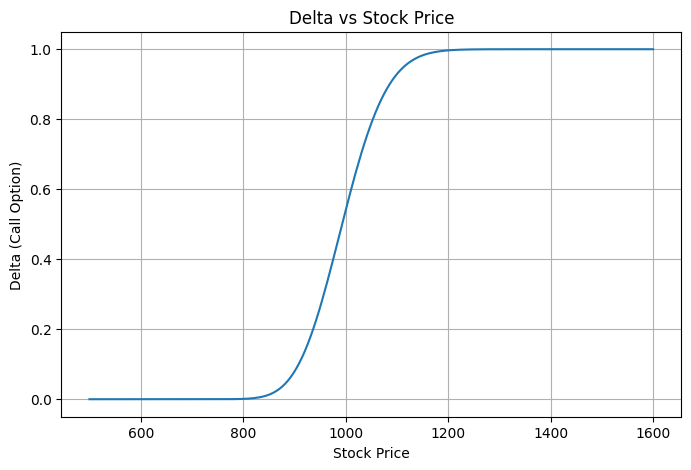

In [8]:
# Sample parameters
K = 1000
T = 30.0 / 365
S_values = np.linspace(500, 1600, 200) # Range of stock prices

# Compute delta for each S
delta_values = [bsm_price(S, K, T, r, annualized_vol, output='delta', option_type='call') for S in S_values]

# Plot
plt.figure(figsize=(8,5))
plt.plot(S_values, delta_values)
plt.xlabel("Stock Price")
plt.ylabel("Delta (Call Option)")
plt.title("Delta vs Stock Price")
plt.grid(True)
plt.show()


Now, to compare Vega and Volatility, we can simulate the BSM model over a sample data by fixing the spot and strike price arbitrarily as an ATM option, time to maturity as 1 month, sigma as annualized volatility and risk free rate as inferred earlier from repo rate.

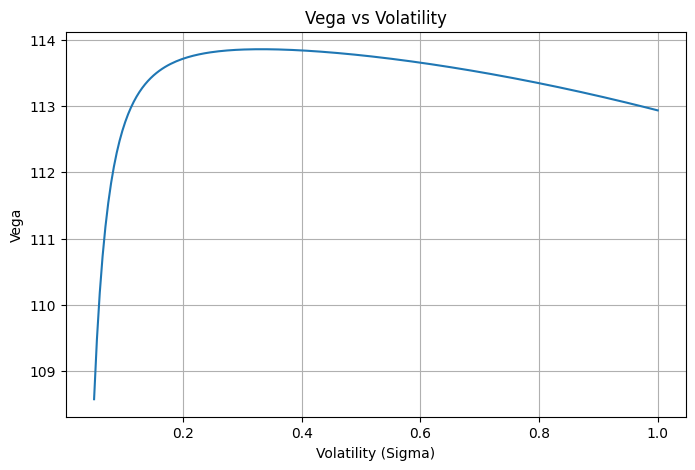

In [9]:
# Fixed parameters
S = 1000
K = 1000
T = 30.0 / 365
sigma_values = np.linspace(0.05, 1, 200) # Volatility range

# Compute vega for each sigma
vega_values = [bsm_price(S, K, T, r, sigma, output='vega') for sigma in sigma_values]

# Plot
plt.figure(figsize=(8,5))
plt.plot(sigma_values, vega_values)
plt.xlabel("Volatility (Sigma)")
plt.ylabel("Vega")
plt.title("Vega vs Volatility")
plt.grid(True)
plt.show()